<hr/>


# Machine learning models

Indicators which are used for training models are analyzed in indicators notebook

<hr/>


### Imports

In [1]:
import matplotlib
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import yfinance as yf
from talib.abstract import *
from datetime import datetime
from math import isclose

# Parameters

In [2]:
fetch_from_yahoo = True

# 'AAPL', 'TSLA', 'AMD', 'NVDA', 'BTC-USD', 'LINK-USD', 'ADA-USD'
ticker = 'BTC-USD' 

# Indicator timeperiod
timeperiod=200

# Aggregate minute data into n data
# '30T' for 30 min candles, '1h' for 1 hour candles...
aggregate='4h'

# Classification percentage threshold
# This parameter affects stoploss for trading, stoploss = threshold / 3
threshold = 0.01

# Split data into train/test
train_size = 0.8
test_size = 0.2

<hr/>

# Data reading

<hr/>

### Fetching daily candles from yahoo finance or minute candles from local folder

In [3]:
if fetch_from_yahoo:
    dt_start = dt.datetime(1990, 1, 1)
    dt_end = dt.datetime.now()

    df = yf.download(ticker, start=dt_start, end=dt_end, group_by="ticker") 
    df.drop(['Adj Close'], axis=1, inplace=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']

else:
    df = pd.read_csv(f'..\\data\\{ticker}_1m.csv', index_col='date')
    df.index = pd.to_datetime(df.index)
    
    ohlc_dict = {
        'open': 'first',                                                                                                    
        'close': 'last',                                                                                                       
        'high': 'max',                                                                                                        
        'low': 'min',                                                                                                    
        'volume': 'sum',
    }

    df = df.resample(aggregate, closed='left', label='left').apply(ohlc_dict).dropna()
    
df 

[*********************100%***********************]  1 of 1 completed


open          high           low         close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2022-04-09  42282.078125  42786.816406  42183.253906  42782.136719   
2022-04-10  42781.089844  43376.378906  42021.207031  42207.671875   
2022-04-11  42201.039062  42424.589844  39373.058594  39521.902344   
2022-04-12  39533.714844  40617.585938  39388.328125  40127.183594   
2022-04-13  40092.164062  40230.250000  39720.531250  40171.156250   

                 volume  
Date                     
2014-09-17     21056800  
2014-09-18     34483200  
2014-09-19     37919700  
2014-09-20     36863600  
2014-09-21     26580100  
...                 ...  
2022-04-09  16050772496  
2022-04-10  17654475582  
2022-04-11  33949912166  
2022-04-12  30991500854  
2022-04-13  28992911360  

[2766 rows x 5 columns]

### Converting data to dictionary for ta-lib

In [4]:
data = {
    'open': df['open'].values.astype('float64'),
    'high': df['high'].values.astype('float64'),
    'low': df['low'].values.astype('float64'),
    'close': df['close'].values.astype('float64'),
    'volume': df['volume'].values.astype('float64')
}

In [5]:
data

{'open': array([  465.86401367,   456.85998535,   424.10299683, ...,
        42201.0390625 , 39533.71484375, 40092.1640625 ]),
 'high': array([  468.17401123,   456.85998535,   427.83499146, ...,
        42424.58984375, 40617.5859375 , 40230.25      ]),
 'low': array([  452.42199707,   413.10400391,   384.53201294, ...,
        39373.05859375, 39388.328125  , 39720.53125   ]),
 'close': array([  457.33401489,   424.44000244,   394.79598999, ...,
        39521.90234375, 40127.18359375, 40171.15625   ]),
 'volume': array([2.10568000e+07, 3.44832000e+07, 3.79197000e+07, ...,
        3.39499122e+10, 3.09915009e+10, 2.89929114e+10])}

<hr/>

# Utility functions

<hr/>

### Extract indicator info

In [6]:
def name(function):
    try:
        return function.__name__
    except:
        return str(function).split('(')[0].strip()

def full_name(function):
    val = str(function).split('(')
    return val[1].split('\n')[-1].strip()

print(name(SMA), full_name(SMA))

SMA Simple Moving Average


### Display class balance

In [7]:
def display_class_balance(y):
    classifications, occurances = np.unique(y, return_counts=True)
    
    for i, classification in enumerate(classifications):
        print(f"Class {classification:2d} occured {occurances[i]:8d} times. This class makes {occurances[i]/len(y) * 100:2.2f}% of all labels")

### Checking the percentage of correct predictions for wanted classes

In [8]:
def score_performance(y_test, prediction, classes=[-1, 1]):
    correct = 0
    all = 0
    for i in range(len(y_test)):
        if y_test[i] in classes:
            all += 1
            if y_test[i] == prediction[i]:
                correct += 1

    return correct / all

score_performance([1, 0, 0, -1, 1], [-1, -1, 0, -1, 1])

0.6666666666666666

<hr/>


# Creating indicators

<hr/>


### Moving averages

In [9]:
ma_types = [SMA, EMA, WMA]

for ma_type in ma_types:
    df[name(ma_type)] = ma_type(data, timeperiod=timeperiod)

### Bolinger bands

In [10]:
indicator = BBANDS

df[f'{name(indicator)}_upper'], df[f'{name(indicator)}_middle'], df[f'{name(indicator)}_lower'] = indicator(data
, timeperiod=21, nbdevup=2., nbdevdn=2.)

### Kaufman Adaptive Moving Average

In [11]:
indicator = KAMA

df[name(indicator)] = indicator(data)

### Absolute Price Oscillator

In [12]:
indicator = APO

df[name(indicator)] = indicator(data)

### Commodity Channel Index

In [13]:
indicator = CCI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Money Flow Index

In [14]:
indicator = MFI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Momentum

In [15]:
indicator = MOM

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Rate of change

In [16]:
indicator = ROC

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Relative Strength Index

In [17]:
indicator = RSI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Williams' %R

In [18]:
indicator = WILLR

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Beta

In [19]:
indicator = BETA

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Pearson's Correlation Coefficient (r)

In [20]:
indicator = CORREL

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Linear Regression Angle

In [21]:
indicator = LINEARREG_ANGLE 

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Hilbert Transform - Dominant Cycle Phase

In [22]:
indicator = HT_DCPHASE 

df[name(indicator)] = indicator(data)

<hr/>

# Data processing

<hr/>

### Dropping nan rows

In [23]:
df.dropna(inplace=True)

df

open          high           low         close  \
Date                                                                 
2015-04-05    253.761002    260.674988    251.942001    260.597992   
2015-04-06    260.721008    261.798004    254.574997    255.492004   
2015-04-07    255.274002    255.804993    252.205002    253.179993   
2015-04-08    253.063995    253.847000    244.214996    245.022003   
2015-04-09    244.751007    246.117996    239.399994    243.675995   
...                  ...           ...           ...           ...   
2022-04-09  42282.078125  42786.816406  42183.253906  42782.136719   
2022-04-10  42781.089844  43376.378906  42021.207031  42207.671875   
2022-04-11  42201.039062  42424.589844  39373.058594  39521.902344   
2022-04-12  39533.714844  40617.585938  39388.328125  40127.183594   
2022-04-13  40092.164062  40230.250000  39720.531250  40171.156250   

                 volume           SMA           EMA           WMA  \
Date                                                                
2015-04-05     19649200    309.859490    310.343218    280.173399   
2015-04-06     20034200    309.014750    309.797435    279.632429   
2015-04-07     18467400    308.306670    309.234077    279.076860   
2015-04-08     30086400    307.487260    308.595151    278.447161   
2015-04-09     21643500    306.711535    307.949189    277.812223   
...                 ...           ...           ...           ...   
2022-04-09  16050772496  48231.880996  44768.419459  44918.588475   
2022-04-10  17654475582  48225.046816  44742.939384  44858.646096   
2022-04-11  33949912166  48198.180840  44690.988766  44772.047643   
2022-04-12  30991500854  48184.618008  44645.577770  44691.739213   
2022-04-13  28992911360  48171.890820  44601.056163  44612.003275   

            BBANDS_upper  BBANDS_middle  ...        CCI        MFI  \
Date                                     ...                         
2015-04-05    281.656047     256.824143  ... -62.824433  52.539085   
2015-04-06    274.865088     255.152668  ... -62.645167  52.853275   
2015-04-07    267.908982     253.613382  ... -66.202842  53.199185   
2015-04-08    267.769790     253.076381  ... -72.713236  52.515523   
2015-04-09    267.029363     252.254857  ... -77.515293  52.692833   
...                  ...            ...  ...        ...        ...   
2022-04-09  48598.529028   44617.469494  ... -52.248157  48.880952   
2022-04-10  48508.151658   44663.176525  ... -52.688966  48.483833   
2022-04-11  48754.215652   44589.076823  ... -71.826259  48.004635   
2022-04-12  48971.445359   44482.808966  ... -75.238566  48.100024   
2022-04-13  49163.628474   44353.199405  ... -75.058291  48.129085   

                    MOM        ROC        RSI      WILLR      BETA    CORREL  \
Date                                                                           
2015-04-05  -196.736023 -43.018017  44.397749 -68.804866  0.509039  0.984024   
2015-04-06  -168.947998 -39.804919  44.268371 -70.592783  0.503960  0.984108   
2015-04-07  -141.615997 -35.870678  44.209743 -71.402359  0.496397  0.984313   
2015-04-08  -163.881989 -40.078354  44.003080 -74.258968  0.497487  0.984333   
2015-04-09  -155.145020 -38.900914  43.968998 -74.730288  0.499558  0.984199   
...                 ...        ...        ...        ...       ...       ...   
2022-04-09  2088.460938   5.132151  50.038458 -73.043321  0.464088  0.989390   
2022-04-10 -1366.835938  -3.136779  49.908850 -74.656734  0.462538  0.989432   
2022-04-11 -5373.195312 -11.968334  49.308739 -82.199851  0.463028  0.989419   
2022-04-12 -2712.566406  -6.331891  49.446419 -80.499889  0.459276  0.989583   
2022-04-13 -2545.437500  -5.958896  49.456442 -80.376390  0.469094  0.989561   

            LINEARREG_ANGLE  HT_DCPHASE  
Date                                     
2015-04-05       -41.830388   14.938371  
2015-04-06       -41.537705   24.343516  
2015-04-07       -41.389754   32.623899  
2015-04-08       -41.204769   39.228655  
2015-04

### Creating data labels

In [24]:
# x1 is value preceding x2
def compare(x1, x2, rtol):
    if np.isclose(x1, x2, rtol=rtol):
        return 0
    if x1 > x2:
        return -1
    return 1
    
print(compare(100, 99.94, 0.0005), compare(100, 99.96, 0.001))    

-1 0


In [25]:
def create_classification(close_arr):
    classification = []
    for i in range(len(close_arr) - 1):
        classification.append(compare(close_arr[i], close_arr[i + 1], threshold))
        
    return np.array(classification)

In [26]:
y = create_classification(df['close'])

y.shape

(2565,)

### Data scaling

https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

In [27]:
from sklearn.preprocessing import StandardScaler

cols = ['open', 'high', 'low', 'close', 'SMA', 'EMA', 'WMA', 'BBANDS_upper', 'BBANDS_middle', 'BBANDS_lower', 'KAMA']
scaler = StandardScaler()

def scale(df):
    scaled_df = df.copy()
    scaled_df[cols] = df[cols].div(df['open'], axis=0)
    return pd.DataFrame(scaler.fit_transform(scaled_df.values), columns=scaled_df.columns, index=scaled_df.index)

In [28]:
x = scale(df)[:-1].values

x.shape

(2565, 23)

### Data splitting

In [29]:
x_train = x[:int(len(x) * train_size)]
x_test = x[-int(len(x) * test_size):]
y_train = y[:int(len(x) * train_size)]
y_test = y[-int(len(x) * test_size):]

In [30]:
print(f"x_train shape: {x_train.shape}; y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}; y_test shape: {y_test.shape}")

x_train shape: (2052, 23); y_train shape: (2052,)
x_test shape: (513, 23); y_test shape: (513,)


In [31]:
print("Y train class balance:")
display_class_balance(y_train)

Y train class balance:
Class -1 occured      536 times. This class makes 26.12% of all labels
Class  0 occured      817 times. This class makes 39.81% of all labels
Class  1 occured      699 times. This class makes 34.06% of all labels


In [32]:
print("Y test class balance:")
display_class_balance(y_test)

Y test class balance:
Class -1 occured      174 times. This class makes 33.92% of all labels
Class  0 occured      146 times. This class makes 28.46% of all labels
Class  1 occured      193 times. This class makes 37.62% of all labels


<hr/>

# Model training and evaluating

<hr/>

In [33]:
from sklearn import svm

model = svm.SVC(kernel="linear", class_weight='balanced').fit(x_train, y_train) 

#### TODO: Implement a loss function that punishes false signals way harder than not making signals even though there was a signal

In [34]:
print(f"Model achieved accuracy of {model.score(x_test, y_test) * 100:3.2f}%")

Model achieved accuracy of 33.72%


In [35]:
prediction = model.predict(x_test)

In [36]:
display_class_balance(prediction)

Class -1 occured      390 times. This class makes 76.02% of all labels
Class  0 occured       71 times. This class makes 13.84% of all labels
Class  1 occured       52 times. This class makes 10.14% of all labels


### Checking the percentage of correct predictions for wanted classes

In [37]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [0]) * 100:3.2f}% on class 0")

Model achieved accuracy of 14.38% on class 0


In [38]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [1]) * 100:3.2f}% on class 1")

Model achieved accuracy of 12.95% on class 1


In [39]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [-1]) * 100:3.2f}% on class -1")

Model achieved accuracy of 72.99% on class -1


### Graph overlay with predictions

In [40]:
test_df = df[['open', 'high', 'low', 'close']][-(len(prediction) + 1):-1]
test_df['prediction'] = prediction
test_df['real'] = y_test

### Calculating returns over test period

In [41]:
trades = pd.DataFrame()

for i in range(len(test_df) - 1):
    row = test_df.iloc[i]
    if row['prediction'] == 1:
        next_row = test_df.iloc[i + 1]
        stoploss = row['close'] * (1 - threshold / 4)
        
        if next_row['low'] < stoploss:
            roi = (1 - threshold / 4)
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':stoploss, 'type':'long', 'roi':roi, 'stoploss':"yes"}, ignore_index=True)
        else:
            roi = next_row['close'] / row['close']
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':next_row['close'], 'type':'long', 'roi':roi}, ignore_index=True)
        
    elif row['prediction'] == -1:
        next_row = test_df.iloc[i + 1]
        stoploss = row['close'] * (1 + threshold / 4)
        
        if next_row['high'] > stoploss:
            roi = (1 - threshold / 4)
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':stoploss, 'type':'short', 'roi':roi, 'stoploss':"yes"}, ignore_index=True)
        else:
            roi = row['close'] / next_row['close']
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':next_row['close'], 'type':'short', 'roi':roi}, ignore_index=True)
        
print(f"Model achieved increase of {trades['roi'].prod():6.4f} times trading from {test_df.iloc[0].name} to {test_df.iloc[-1].name}")

trades.set_index('date', inplace=True)
trades.sort_values(by=['roi'])

Model achieved increase of 1.6914 times trading from 2020-11-16 00:00:00 to 2022-04-12 00:00:00


entry          exit   type       roi stoploss
date                                                            
2020-11-16  16716.111328  16674.321050   long  0.997500      yes
2021-09-20  42843.800781  42736.691279   long  0.997500      yes
2021-09-17  47267.519531  47385.688330  short  0.997500      yes
2021-09-16  47783.359375  47902.817773  short  0.997500      yes
2021-09-15  48176.347656  48296.788525  short  0.997500      yes
...                  ...           ...    ...       ...      ...
2022-03-03  42451.789062  39137.605469  short  1.084680      NaN
2021-09-19  47260.218750  42843.800781  short  1.103082      NaN
2021-02-22  54207.320312  48824.425781  short  1.110250      NaN
2021-06-20  35698.296875  31676.693359  short  1.126958      NaN
2021-01-20  35547.750000  30825.699219  short  1.153186      NaN

[441 rows x 5 columns]

In [42]:
print(f"Winning trades: {len(trades[trades['roi'] > 1])}, losing trades: {len(trades[trades['roi'] < 1])}")

Winning trades: 30, losing trades: 411


### Graph overlay with predictions

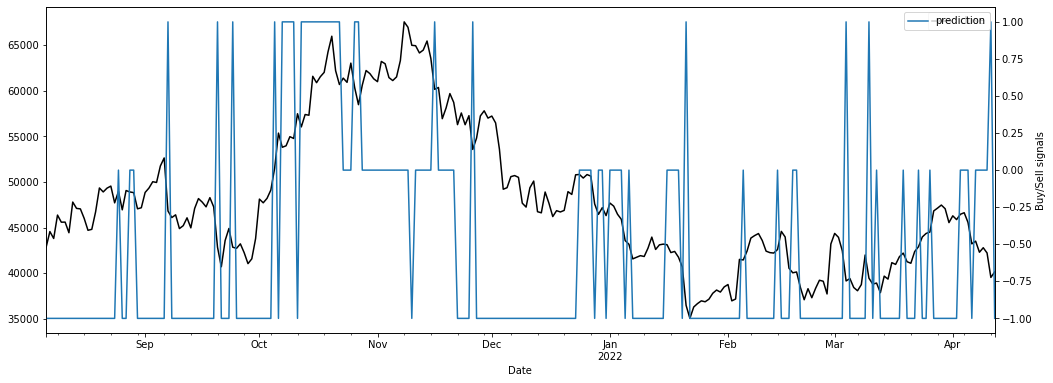

In [43]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

test_df[['close']][-250:].plot(figsize=(17,6), ax=ax1, color='k')
test_df[['prediction']][-250:].plot(figsize=(17,6), ax=ax2, ylabel="Buy/Sell signals")

plt.show()

In [44]:
test_df.tail(n=50)

open          high           low         close  \
Date                                                                 
2022-02-22  37068.769531  38359.855469  36488.933594  38286.027344   
2022-02-23  38285.281250  39122.394531  37201.816406  37296.570312   
2022-02-24  37278.566406  38968.839844  34459.218750  38332.609375   
2022-02-25  38333.746094  39630.324219  38111.343750  39214.218750   
2022-02-26  39213.082031  40005.347656  38702.535156  39105.148438   
2022-02-27  39098.699219  39778.941406  37268.976562  37709.785156   
2022-02-28  37706.000000  43760.457031  37518.214844  43193.234375   
2022-03-01  43194.503906  44793.601562  42952.585938  44354.636719   
2022-03-02  44357.617188  45077.578125  43432.851562  43924.117188   
2022-03-03  43925.195312  44021.578125  41914.750000  42451.789062   
2022-03-04  42458.140625  42479.613281  38805.847656  39137.605469   
2022-03-05  39148.449219  39566.335938  38777.035156  39400.585938   
2022-03-06  39404.199219  39640.175781  38211.648438  38419.984375   
2022-03-07  38429.304688  39430.226562  37260.203125  38062.039062   
2022-03-08  38059.902344  39304.441406  37957.386719  38737.269531   
2022-03-09  38742.816406  42465.671875  38706.093750  41982.925781   
2022-03-10  41974.070312  42004.726562  38832.941406  39437.460938   
2022-03-11  39439.968750  40081.679688  38347.433594  38794.972656   
2022-03-12  38794.464844  39308.597656  38772.535156  38904.011719   
2022-03-13  38884.726562  39209.351562  37728.144531  37849.664062   
2022-03-14  37846.316406  39742.500000  37680.734375  39666.753906   
2022-03-15  39664.250000  39794.628906  38310.210938  39338.785156   
2022-03-16  39335.570312  41465.453125  39022.347656  41143.929688   
2022-03-17  41140.843750  41287.535156  40662.871094  40951.378906   
2022-03-18  40944.839844  42195.746094  40302.398438  41801.156250   
2022-03-19  41794.648438  42316.554688  41602.667969  42190.652344   
2022-03-20  42191.406250  42241.164062  41004.757812  41247.824219   
2022-03-21  41246.132812  41454.410156  40668.042969  41077.996094   
2022-03-22  41074.105469  43124.707031  40948.281250  42358.808594   
2022-03-23  42364.378906  42893.507812  41877.507812  42892.957031   
2022-03-24  42886.652344  44131.855469  42726.164062  43960.933594   
2022-03-25  43964.546875  44999.492188  43706.285156  44348.730469   
2022-03-26  44349.859375  44735.996094  44166.273438  44500.828125   
2022-03-27  44505.355469  46827.546875  44437.292969  46820.492188   
2022-03-28  46821.851562  48086.835938  46690.203125  47128.003906   
2022-03-29  47100.437500  48022.289062  47100.437500  47465.730469   
2022-03-30  47456.898438  47655.148438  46746.210938  47062.664062   
2022-03-31  47062.148438  47512.027344  45390.539062  45538.675781   
2022-04-01  45554.164062  46616.242188  44403.140625  46281.644531   
2022-04-02  46285.500000  47028.281250  45782.511719  45868.949219   
2022-04-03  45859.128906  47313.476562  45634.105469  46453.566406   
2022-04-04  46445.273438  46791.089844  45235.816406  46622.675781   
2022-04-05  46624.507812  47106.140625  45544.808594  45555.992188   
2022-04-06  45544.355469  45544.355469  43193.953125  43206.738281   
2022-04-07  43207.500000  43860.699219  42899.906250  43503.847656   
2022-04-08  43505.136719  43903.019531  42183.289062  42287.664062   
2022-04-09  42282.078125  42786.816406  42183.253906  42782.136719   
2022-04-10  42781.089844  43376.378906  42021.207031  42207.671875   
2022-04-11  42201.039062  42424.589844  39373.058594  39521.902344   
2022-04-12  39533.714844  40617.585938  39388.328125  40127.183594   

            prediction  real  
Date                          
2022-02-22          -1    -1  
2022-02-23          -1     1  
2022-02-24          -1     1  
2022-02-25          -1     0  
2022-02-26          -1    -1  
2022-02-27          -1     1  
2022-02-28          -1     1  
2022-03-01          -1     0  
2022-03-02          -1    -1  
2022-03-03          -1    -1  
2022-03